# Credit Card Fraud Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Functions

In [23]:
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV


def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('model', model)
        ])
            
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        f2 = f2_measure(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print(f"F2 Score: {f2:.3f}")
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                'F2 Score':f2,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# EDA Analysis

# Read in a subset of the data and try to match the class imbalance in the original dataset.

In [5]:
import pandas as pd
import numpy as np

total_samples = 10000
ratio = 258  


positives_needed = total_samples // (ratio + 1)
negatives_needed = total_samples - positives_needed


positives_count = 0
negatives_count = 0


sampled_data = []


chunk_size = 10000

# Randomly sample from each chunk
for chunk in pd.read_csv('data.csv', chunksize=chunk_size):
    # Separate positive and negative cases
    positives = chunk[chunk['is_fraud'] == 1]
    negatives = chunk[chunk['is_fraud'] == 0]

    positives_sample = positives.sample(min(len(positives), positives_needed - positives_count))
    negatives_sample = negatives.sample(min(len(negatives), negatives_needed - negatives_count))

    positives_count += len(positives_sample)
    negatives_count += len(negatives_sample)

    sampled_data.append(positives_sample)
    sampled_data.append(negatives_sample)

    # Break if we have enough samples
    if positives_count >= positives_needed and negatives_count >= negatives_needed:
        break

# Concatenate all sampled data into a single DataFrame
final_sample = pd.concat(sampled_data, ignore_index=True)

# Shuffle the final sample to mix positive and negative cases
df = final_sample.sample(frac=1).reset_index(drop=True)

In [5]:
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [61]:
target = df.values[:,-1]

counter = Counter(target)

for k, v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=0, Count=9962, Percentage=99.620%
Class=1, Count=38, Percentage=0.380%


# Important lesson for ML engineers, the class balance is 258:1 for the original dataset, in our sample it is 262:1. This means For every 258 examples of the majoirty class, there is only one from the minority class. Posting a 99% accuracy score shows a misunderstanding of the problem at hand. Because there are so few fraud examples, the model will not be able to predict the minority class which is costly to the business.

## Business Problem:

### Fraud cases are costly to banks, false negatives will be far more costly to their bottome line than false positives.

* Accuracy and F1 score's are irrelevant in this instance
* F1 score's and accuracy scores do not penalize false negatives
* F2 score's are what should be measured since they give greater weight to false positives.

In [8]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

# Feature Engineering

In [6]:
CURR_YEAR = 2023
df["gender"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
df["trans_date_trans_time"] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M', errors='coerce')
df["dob"] = pd.to_datetime(df['dob'], format='%d/%m/%Y', errors='coerce')

df['day'] = df['trans_date_trans_time'].dt.day.astype('int64')
df['hour'] = df['trans_date_trans_time'].dt.hour.astype('int64')
df['age'] = (CURR_YEAR - df['dob'].dt.year).astype('int64')

In [7]:
df.drop(["Unnamed: 0", "street", "trans_date_trans_time", "dob"], inplace=True, axis=1)

In [8]:
continuous_features = df.select_dtypes(include=["float64","int64"])
categorical_features = df.select_dtypes(include="object")

In [9]:
from collections import defaultdict

def convert_categorical_to_numerical(column_values:list):
  """
  Takes categorical columns and returns them into one hot encoding columns
  without exploding the amount of columns

  Args:
      column_values (list): tuple list of index, value

  Returns:
      Dictionary Key valued pair
  """
  converted_dict = defaultdict(list)
  
  for k, v in column_values:
    converted_dict[k] = v
  return converted_dict

binary_columns, mapping_dict = [], {}
for col in categorical_features.columns:
  unique_columns_values = categorical_features[col].unique()
  print(f" Col: {col}, Unique list: {len(unique_columns_values)}")
  if len(unique_columns_values) ==2:
    binary_columns.append(col)
  else:
    dict_values = [(value, idx )for (idx, value) in enumerate(sorted(unique_columns_values))]
    mapping_dict[col] = convert_categorical_to_numerical(dict_values)

 Col: merchant, Unique list: 693
 Col: category, Unique list: 14
 Col: first, Unique list: 338
 Col: last, Unique list: 464
 Col: city, Unique list: 831
 Col: state, Unique list: 50
 Col: job, Unique list: 474
 Col: trans_num, Unique list: 10000


In [10]:
# Create copy of Dataframe for feature manipulation
replicate_df = df.copy()
replicate_df

,cc_num,merchant,category,amt,first,last,gender,city,state,zip,...,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,day,hour,age
0,3.019960e+13,"fraud_Willms, Kris and Bergnaum",shopping_pos,12.39,Theresa,Powell,0,Leonard,TX,75452,...,4090,Sub,0d244bcda5d01f6769a30e6c4aadb4d4,1372009182,33.281265,-95.297016,0,23,17,46
1,3.534090e+15,fraud_Wilkinson LLC,personal_care,32.35,Jeremy,White,1,Boulder,MT,59632,...,1939,Patent attorney,ae739e575d06fbe77c253511e81b9796,1372000371,45.465075,-111.826433,0,23,15,56
2,4.600160e+12,"fraud_Raynor, Reinger and Hagenes",gas_transport,82.17,Charles,Copeland,1,West Palm Beach,FL,33404,...,459921,"Administrator, arts",8afb05c5259e8654ccbec7658e84119f,1371970583,27.550255,-80.612703,0,23,6,54
3,6.042310e+10,fraud_Johnston-Casper,travel,1.17,Jason,Gray,1,Amorita,OK,73719,...,83,Barrister's clerk,d324252de116fd53f656cc5f6ba98d83,1371994528,37.078712,-98.698609,0,23,13,65
4,4.328930e+15,"fraud_Haley, Jewess and Bechtelar",shopping_pos,6.74,Margaret,Ray,0,Greendale,WI,53129,...,13973,Logistics and distribution manager,87e41b7e8eaf5cb81fb2eb2d1c447164,1371830802,42.368731,-87.663919,0,21,16,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.672270e+13,fraud_Stamm-Witting,shopping_net,3.22,Jessica,Perez,0,Superior,AZ,85173,...,2872,Petroleum engineer,d36f65d6b47df23a415addf866c64368,1372013766,34.002558,-110.822384,0,23,18,36
9996,4.223710e+18,fraud_Bahringer-Streich,food_dining,54.98,Adam,Riddle,1,Mount Saint Joseph,OH,45051,...,177,Exhibition designer,50c87896fbc186a802d63fe8fbd16aa6,1372004250,38.722929,-84.184156,0,23,16,49
9997,3.534330e+15,"fraud_Bahringer, Bergnaum and Quitzon",home,75.63,Jeffrey,Smith,1,Bridger,MT,59014,...,1446,Chartered loss adjuster,c10e1eae8857ad3ef580dfc2f3056dae,1371859160,45.853662,-109.444386,0,21,23,45
9998,3.019740e+13,fraud_Harris Group,food_dining,148.41,April,Johnson,0,Creedmoor,NC,27522,...,12335,Chief Strategy Officer,03488a09e44ddb458ffdda556f4df088,1371917220,35.890895,-78.298085,0,22,16,36


In [11]:
for k, v in mapping_dict.items():
  replicate_df[k] = replicate_df[k].apply(lambda x: v[x])

# Visuals

<Axes: >

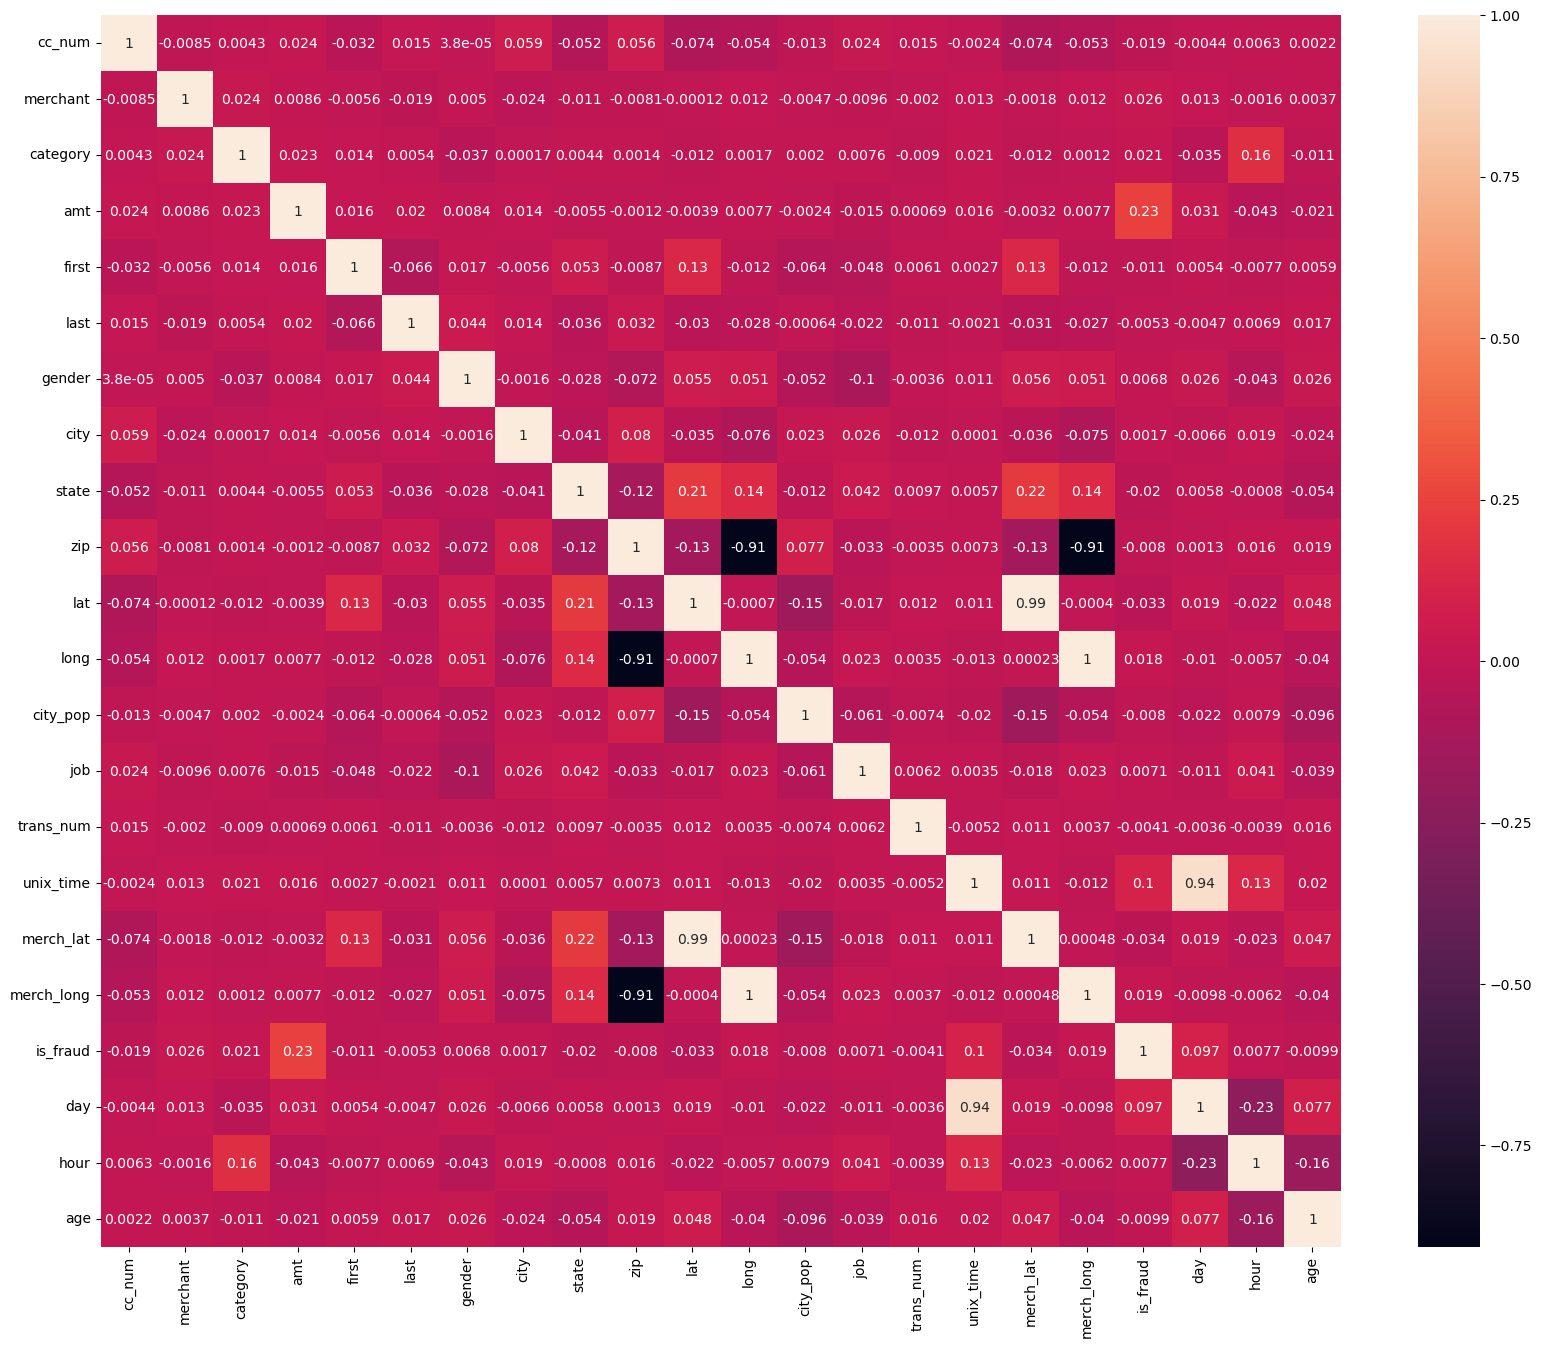

In [12]:
relations = replicate_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(data=relations, annot=True)

# Separate Feature and Target variables

In [13]:
X, y = replicate_df.drop("is_fraud", axis=1), replicate_df["is_fraud"]

# Baseline Model Evaluation

In [14]:
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean F2: 0.019 (0.002)


# Feature Importance

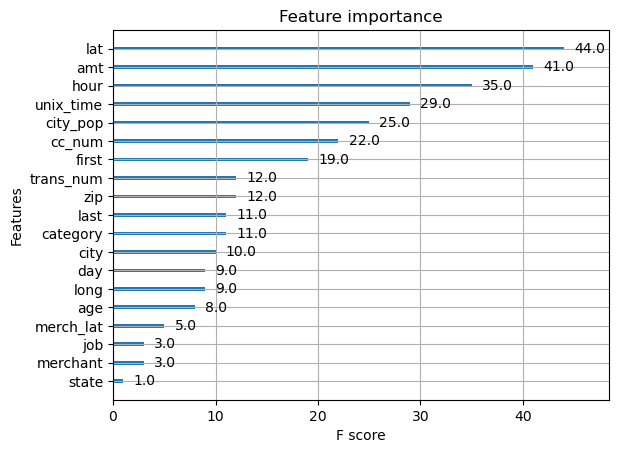

In [15]:
# fit model on training data
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

# Spot Check Algorithms

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = spot_check_models(X_train_scaled, X_test_scaled, y_train, y_test)
models

63/63 [==============================] - 0s 397us/step - loss: 0.0000e+00 - accuracy: 0.9975


,Model,Accuracy
2,GPC,0.9985
6,DecisionTreeClassifier,0.9985
7,RandomForestClassifier,0.9985
9,XGB,0.9985
4,SVC,0.9980
5,KNeighborsClassifier,0.9980
10,Sequential,0.9975
8,GradientBoostingClassifier,0.9970
3,LogisticRegression,0.9965
1,LDA,0.9900


# Model Analysis - These scores are all hot air given that we tested only on accuracy and not on F2 scores which do not penalize for False Negatives in the scoring. Let us test on F2 scores

# Advanced Model Metrics

In [106]:
names = ["XGB", "DTC", "GBC", "RFC", "LDA", "SVC", "LR", "GNB"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y)

>XGB 0.742 (0.237)
>DTC 0.840 (0.132)
>GBC 0.807 (0.163)
>RFC 0.812 (0.162)
>LDA 0.461 (0.298)
>SVC 0.534 (0.270)
>LR 0.271 (0.221)
>GNB 0.521 (0.125)


# HyperParameter Tuning

Best score for XGB: 0.730
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Test accuracy for XGB: 1.000
F2 Score: 0.962
---------------------------------------------------------------


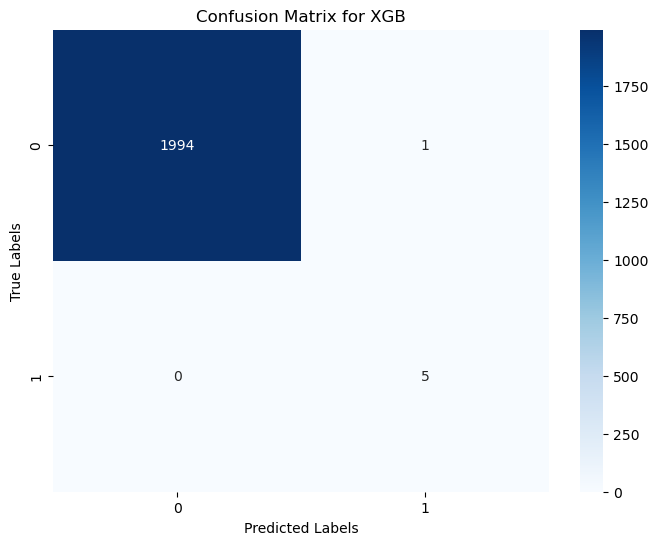

Best score for DTC: 0.849
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__splitter': 'random'}
Test accuracy for DTC: 0.997
F2 Score: 0.806
---------------------------------------------------------------


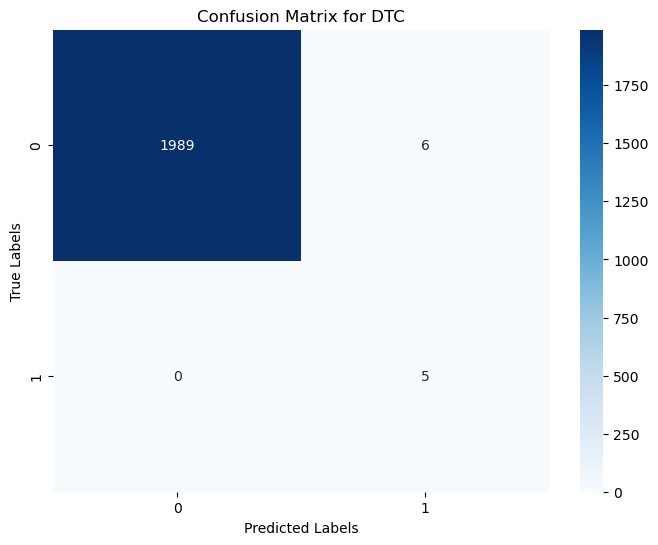

Best score for GBC: 0.846
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300}
Test accuracy for GBC: 1.000
F2 Score: 0.833
---------------------------------------------------------------


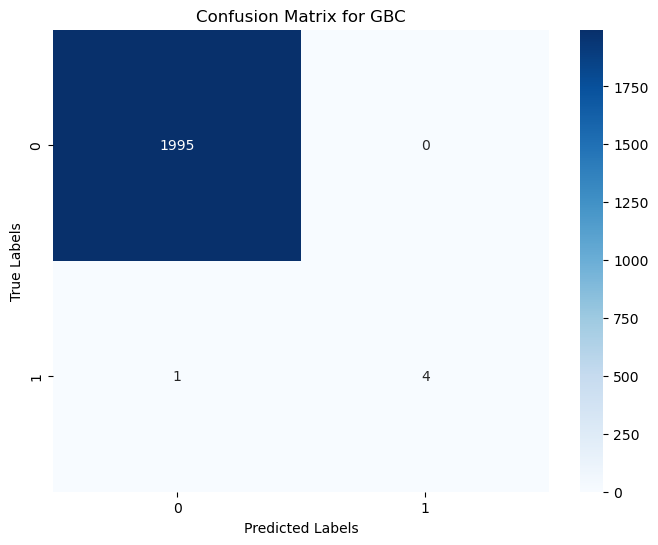

Best score for RFC: 0.790
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Test accuracy for RFC: 1.000
F2 Score: 0.833
---------------------------------------------------------------


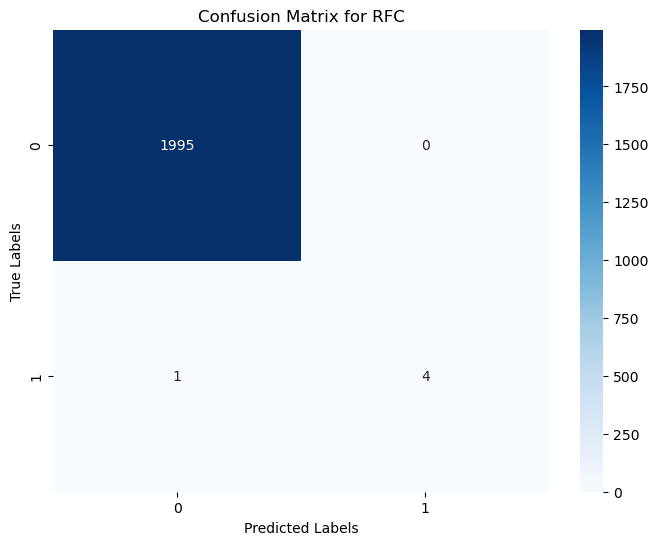

  Model  Best CV Score  Test Accuracy  F2 Score  \
0   XGB       0.729909         0.9995  0.961538   
1   DTC       0.849049         0.9970  0.806452   
2   GBC       0.846235         0.9995  0.833333   
3   RFC       0.790315         0.9995  0.833333   

                                     Best Parameters  
0  {'model__learning_rate': 0.1, 'model__max_dept...  
1  {'model__criterion': 'gini', 'model__max_depth...  
2  {'model__learning_rate': 0.1, 'model__max_dept...  
3  {'model__max_depth': None, 'model__min_samples...  


In [24]:
names = ["XGB", "DTC", "GBC", "RFC"]
models = get_selected_models(names)

param_grid = {
  'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}
metric = make_scorer(f2_measure)
grid_search_selected_models(param_grid, names, models, X, y, metric)

# Conclusion

## Notice in our model, we heavily penalize F2 so the model loses accuracy in favor of preventing false negatives which would be extremely costly to the bank. It is better to live with false positives rather than false negatives.